<h1> Training the machine learning models

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import CuDNNGRU,CuDNNLSTM,LSTM, Bidirectional, GlobalMaxPool1D, Dropout,GRU
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import tensorflow
tensorflow.version

<module 'tensorflow._api.v1.version' from 'C:\\Users\\Vinayak\\AppData\\Roaming\\Python\\Python36\\site-packages\\tensorflow\\_api\\v1\\version\\__init__.py'>

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
max_features = 20000
maxlen = 200

In [6]:
#reading the dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.sample(frac=1)

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
59622,9fa30e3c03a7631f,"""\n\n Good Article promotion \n\n Congratulat...",0,0,0,0,0,0
9814,19f51cd2a03c768d,""" February 2010 (UTC)\n1 -although I'm not fus...",0,0,0,0,0,0
150922,746596d2665cecbe,"""\nCome on now, forgive me and forget the inci...",0,0,0,0,0,0
34047,5ad44966ce9e2e8a,"s, which is 1.95*2.6=5.07 CPU cycles need for ...",0,0,0,0,0,0
134545,cf7aae9e0811088c,"""\n Yes, reverted, and back to the prior versi...",0,0,0,0,0,0


In [8]:
list_sentences_train = train["comment_text"].values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [9]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)


In [10]:
list_sentences_test = test["comment_text"].values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [11]:
from keras import backend as K

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
   
    precisionf = precision(y_true, y_pred)
    recallf = recall(y_true, y_pred)
    return 2*((precisionf*recallf)/(precisionf+recallf+K.epsilon()))


def hamming_loss(y_true, y_pred):
        return K.mean(y_true*(1-y_pred)+(1-y_true)*y_pred)


In [12]:
import time
from keras.callbacks import Callback

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()


<h4> GRU Model 

In [13]:
from keras import regularizers

def GRU_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = CuDNNGRU(50, return_sequences=True,name='GRU_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1,precision,recall,hamming_loss])

    return model

model1 = GRU_model()
batch_size = 32
epochs = 3

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
X_tr, X_val, y_tr, y_val = train_test_split(X_t, y, train_size=0.8, random_state=14)

C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
model1_history=model1.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 263s 2ms/step - loss: 0.0669 - acc: 0.9782 - f1: 0.5585 - precision: 0.6670 - recall: 0.5203 - hamming_loss: 0.0369 - val_loss: 0.0483 - val_acc: 0.9820 - val_f1: 0.6660 - val_precision: 0.7260 - val_recall: 0.6530 - val_hamming_loss: 0.0293
Epoch 2/3
127656/127656 [==============================] - 258s 2ms/step - loss: 0.0452 - acc: 0.9832 - f1: 0.6786 - precision: 0.7636 - recall: 0.6457 - hamming_loss: 0.0256 - val_loss: 0.0457 - val_acc: 0.9829 - val_f1: 0.6701 - val_precision: 0.7613 - val_recall: 0.6335 - val_hamming_loss: 0.0286cision: 0.7622 - recall: 0.6459 - ham - ETA: 48s - loss: 0.0451 - acc: 0.9832 - f1: 0.6785 - precision: 0.7620 -  - ETA: 46s - loss: 0.0451 - acc: 0.9832 - f1: 0.6779 - precision: 0.7615 - recall: 0.6460 - hamming_los - ETA: 45s - loss: 0.0451 - acc: 0.9832 - f1: 0.6779 - precision: 0.7614 - recall: 0.6461 - hamming_los - ETA: 45s - loss: 0.0451 

In [ ]:
times = time_callback.times
times

<h4>Bidirectional GRU

In [44]:
def BiGRU_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True,name='Bidirectional_GRU_Layer'),merge_mode='sum')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1,precision,recall,hamming_loss])
    return model
model4_3 = BiGRU_model()
batch_size = 32
epochs = 3


from keras.callbacks import  ModelCheckpoint

file_path4 = "BGRU.model.hdf5"
check= ModelCheckpoint(file_path4, monitor='val_loss', verbose=1,save_best_only=True, mode='min')


model4_3_history=model4_3.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks=[check])
model4_3.load_weights(file_path4)


Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 390s 3ms/step - loss: 0.0631 - acc: 0.9789 - f1: 0.5766 - precision: 0.6801 - recall: 0.5396 - hamming_loss: 0.0346 - val_loss: 0.0464 - val_acc: 0.9828 - val_f1: 0.6640 - val_precision: 0.7475 - val_recall: 0.6339 - val_hamming_loss: 0.0261: 1:28 - loss: 0.0674 - acc: 0.9780 - f1: 0.5525 - precision: 0.6558 - recall: 0.5159 - hamming_loss: 0.03 - E - ETA: 1:13 - loss: 0.0665 - acc: 0.978 - ETA: 1:05 - loss: 0.0662 

Epoch 00001: val_loss improved from inf to 0.04636, saving model to BGRU.model.hdf5
Epoch 2/3
127656/127656 [==============================] - 382s 3ms/step - loss: 0.0444 - acc: 0.9833 - f1: 0.6806 - precision: 0.7717 - recall: 0.6440 - hamming_loss: 0.0253 - val_loss: 0.0458 - val_acc: 0.9831 - val_f1: 0.6598 - val_precision: 0.7802 - val_recall: 0.6072 - val_hamming_loss: 0.0222

Epoch 00002: val_loss improved from 0.04636 to 0.04582, saving model to BGRU.model.

<h4> Bidirectional LSTM

In [32]:
def BiLSTM_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(CuDNNLSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1,precision,recall])

    return model
model2 = BiLSTM_model()
batch_size = 32
epochs = 3

In [33]:

model2_history=model2.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 377s 3ms/step - loss: 0.0670 - acc: 0.9781 - f1: 0.5570 - precision: 0.6607 - recall: 0.5190 - val_loss: 0.0474 - val_acc: 0.9826 - val_f1: 0.6513 - val_precision: 0.7596 - val_recall: 0.6052
Epoch 2/3
127656/127656 [==============================] - 385s 3ms/step - loss: 0.0464 - acc: 0.9829 - f1: 0.6678 - precision: 0.7611 - recall: 0.6305 - val_loss: 0.0476 - val_acc: 0.9830 - val_f1: 0.6661 - val_precision: 0.7618 - val_recall: 0.6279
Epoch 3/3
127656/127656 [==============================] - 376s 3ms/step - loss: 0.0408 - acc: 0.9842 - f1: 0.6971 - precision: 0.7775 - recall: 0.6649 - val_loss: 0.0493 - val_acc: 0.9827 - val_f1: 0.6576 - val_precision: 0.7750 - val_recall: 0.6062


<h4> LSTM Model

In [34]:
def LSTM_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = CuDNNLSTM(50, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1,precision,recall])

    return model
model3 = LSTM_model()
batch_size = 32
epochs = 3

In [45]:
model3_history=model3.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0347 - acc: 0.9862 - f1: 0.7410 - precision: 0.7969 - recall: 0.7225 - val_loss: 0.0483 - val_acc: 0.9826 - val_f1: 0.6653 - val_precision: 0.7491 - val_recall: 0.6366
Epoch 2/3
127656/127656 [==============================] - 267s 2ms/step - loss: 0.0304 - acc: 0.9878 - f1: 0.7712 - precision: 0.8118 - recall: 0.7617 - val_loss: 0.0529 - val_acc: 0.9824 - val_f1: 0.6583 - val_precision: 0.7461 - val_recall: 0.6292
Epoch 3/3
127656/127656 [==============================] - 275s 2ms/step - loss: 0.0266 - acc: 0.9893 - f1: 0.7979 - precision: 0.8276 - recall: 0.7938 - val_loss: 0.0596 - val_acc: 0.9822 - val_f1: 0.6532 - val_precision: 0.7290 - val_recall: 0.6334 0.0267 - acc: 0.9893 - f1: 0.7982 - precision: 0.8277 - recall: 0.794 - ETA: 9s - loss: 0.0267 - acc: 0.98


In [ ]:
times = time_callback.times
times

<h4> Machine Learning Models

In [68]:
from nltk.tokenize import TweetTokenizer
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [69]:
train['comment_text'] = train['comment_text'].map(lambda x: re.sub('\\n',' ',str(x)))
    
# remove any text starting with User... 
train['comment_text'] = train['comment_text'].map(lambda x: re.sub("\[\[User.*",'',str(x)))
    
# remove IP addresses or user IDs
train['comment_text'] = train['comment_text'].map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    
#remove http links in the text
train['comment_text'] = train['comment_text'].map(lambda x: re.sub("(http://.*?\s)|(http://.*)",'',str(x)))


x = train['comment_text']
y = train.iloc[:, 2:8]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=14)


In [71]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = TfidfVectorizer(
    stop_words='english',
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',  #vectorize 2-character words or more
    ngram_range=(1, 1),
    max_features=20000)

word_vectorizer.fit(X_train)
X_train_word_features = word_vectorizer.transform(X_train)


test_features = word_vectorizer.transform(X_test)

<h3> Random Forest

In [85]:
RFscores=[]
RFloss=[]
RFf1=[]
RFprec=[]
RFrecall=[]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

for class_name in list_classes:
    train_target = train[class_name]
    classifier = RandomForestClassifier()

    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name],  scoring='roc_auc'))
    RFscores.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='neg_log_loss'))
    RFloss.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], cv=3, scoring='f1'))
    RFf1.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='precision'))
    RFprec.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='recall'))
    RFrecall.append(cv_score)
    #classifier.fit(X_train_word_features, train_target)
    #y_pre=classifier.predict(test_features)
    #y_pre1_proba = classifier.predict_proba(test_features)
    

C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Vinayak\Anaco

In [87]:
print('Total Accuracy score is {}'.format(np.mean(SVMscores)))
print('Total Loss score is {}'.format(np.mean(SVMloss)))
print('Total F1 score is {}'.format(np.mean(SVMf1)))
print('Total Precision score is {}'.format(np.mean(SVMprec)))
print('Total Recall score is {}'.format(np.mean(SVMrecall)))

Total Accuracy score is 0.8789975360886783
Total Loss score is -0.16655957761382215
Total F1 score is 0.40937101584221774
Total Precision score is 0.6575559303035557
Total Recall score is 0.34113623696351386


<h3> Naive Bayes

In [108]:
NBscores=[]
NBloss=[]
NBf1=[]
NBprec=[]
NBrecall=[]

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

for class_name in list_classes:
    train_target = train[class_name]
    classifier = MultinomialNB()

    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name],  scoring='roc_auc'))
    NBscores.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='neg_log_loss'))
    NBloss.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='f1'))
    NBf1.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='precision'))
    NBprec.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='recall'))
    NBrecall.append(cv_score)
    #classifier.fit(X_train_word_features, train_target)
    #y_pre=classifier.predict(test_features)
    #y_pre1_proba = classifier.predict_proba(test_features)
    


C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the d

In [109]:
print('Total Accuracy score is {}'.format(np.mean(NBscores)))
print('Total Loss score is {}'.format(np.mean(NBloss)))
print('Total F1 score is {}'.format(np.mean(NBf1)))
print('Total Precision score is {}'.format(np.mean(NBprec)))
print('Total Recall score is {}'.format(np.mean(NBrecall)))

Total Accuracy score is 0.913503491009179
Total Loss score is -0.07697485503058117
Total F1 score is 0.27488581880930235
Total Precision score is 0.5969196421150552
Total Recall score is 0.19542683471350195


<h3> Logistic Regression

In [98]:
from sklearn.linear_model import SGDClassifier

LRscores=[]
LRloss=[]
LRf1=[]
LRprec=[]
LRrecall=[]


for class_name in list_classes:
    train_target = train[class_name]
    classifier = SGDClassifier(loss='log')

    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name],  scoring='roc_auc'))
    LRscores.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='neg_log_loss'))
    LRloss.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], cv=3, scoring='f1_macro'))
    LRf1.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='precision_macro'))
    LRprec.append(cv_score)
    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, y_train[class_name], scoring='recall_macro'))
    LRrecall.append(cv_score)

C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\Vinayak\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will

In [107]:
print('Total Accuracy score is {}'.format(np.mean(kscores)))
print('Total Loss score is {}'.format(np.mean(kloss)))
print('Total F1 score is {}'.format(np.mean(kf1)))
print('Total Precision score is {}'.format(np.mean(kprec)))
print('Total Recall score is {}'.format(np.mean(krecall)))

Total Accuracy score is 0.9711573272701647
Total Loss score is -0.08081574308481622
Total F1 score is 0.2549549655639935
Total Precision score is 0.6998449788272608
Total Recall score is 0.168217222688262


<h3> Results

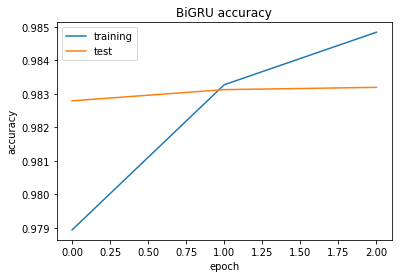

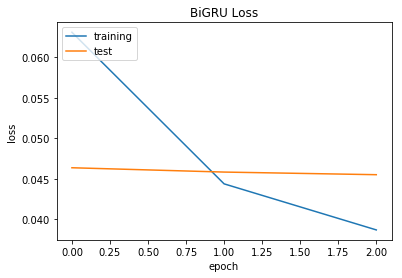

In [66]:
import matplotlib.pyplot as plt


plt.plot(model4_3_history.history['acc'])
plt.plot(model4_3_history.history['val_acc'])
plt.title('BiGRU accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper left')
plt.show()



plt.plot(model4_3_history.history['loss'])
plt.plot(model4_3_history.history['val_loss'])
plt.title('BiGRU Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'test'], loc='upper left')
plt.show()


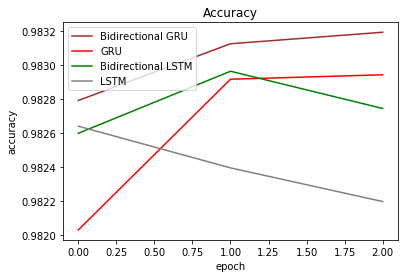

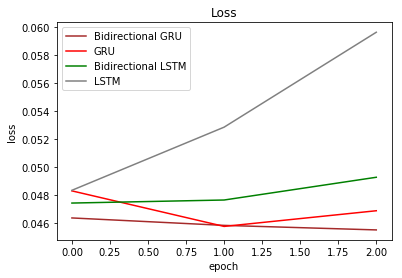

In [47]:
plt.plot(model4_3_history.history['val_acc'],color='brown')
plt.plot(model1_history.history['val_acc'],color='red')
plt.plot(model2_history.history['val_acc'],color='green')
plt.plot(model3_history.history['val_acc'],color='grey')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Bidirectional GRU','GRU', 'Bidirectional LSTM','LSTM'], loc='upper left')
plt.show()


plt.plot(model4_3_history.history['val_loss'],color='brown')
plt.plot(model1_history.history['val_loss'],color='red')
plt.plot(model2_history.history['val_loss'],color='green')
plt.plot(model3_history.history['val_loss'],color='grey')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Bidirectional GRU','GRU', 'Bidirectional LSTM','LSTM'], loc='upper left')
plt.show()



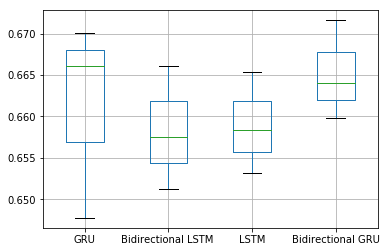

In [48]:
f1_scores=pd.DataFrame(data=[model1_history.history['val_f1'],
                             model2_history.history['val_f1'],
                             model3_history.history['val_f1'],
                             model4_3_history.history['val_f1']
                             ],
                        index=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'],
              columns=['epoch 1','epoch 2','epoch 3'])

f1_scores=f1_scores.T
boxplot1 = f1_scores.boxplot(column=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'])


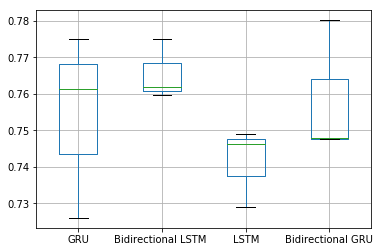

In [49]:
precision_scores=pd.DataFrame(data=[model1_history.history['val_precision'],
                             model2_history.history['val_precision'],
                             model3_history.history['val_precision'],
                             model4_3_history.history['val_precision']
                             ],
                        index=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'],
              columns=['epoch 1','epoch 2','epoch 3'])

precision_scores=precision_scores.T
boxplot1 = precision_scores.boxplot(column=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'])


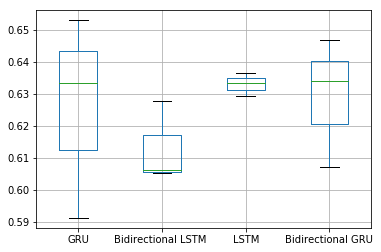

In [50]:
recall_scores=pd.DataFrame(data=[model1_history.history['val_recall'],
                             model2_history.history['val_recall'],
                             model3_history.history['val_recall'],
                             model4_3_history.history['val_recall']
                             ],
                        index=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'],
              columns=['epoch 1','epoch 2','epoch 3'])

recall_scores=recall_scores.T
boxplot1 = recall_scores.boxplot(column=['GRU','Bidirectional LSTM ','LSTM','Bidirectional GRU'])

In [65]:
BiGRU_Acc=np.mean(np.array(model4_3_history.history['val_acc']))
BiGRU_Loss=np.mean(np.array(model4_3_history.history['val_loss']))
BiGRU_f1=np.mean(np.array(model4_3_history.history['val_f1']))
BiGRU_precision=np.mean(np.array(model4_3_history.history['val_precision']))
BiGRU_recall=np.mean(np.array(model4_3_history.history['val_recall']))

GRU_Acc=np.mean(np.array(model1_history.history['val_acc']))
GRU_Loss=np.mean(np.array(model1_history.history['val_loss']))
GRU_f1=np.mean(np.array(model1_history.history['val_f1']))
GRU_precision=np.mean(np.array(model1_history.history['val_precision']))
GRU_recall=np.mean(np.array(model1_history.history['val_recall']))

LSTM_Acc=np.mean(np.array(model3_history.history['val_acc']))
LSTM_Loss=np.mean(np.array(model3_history.history['val_loss']))
LSTM_f1=np.mean(np.array(model3_history.history['val_f1']))
LSTM_precision=np.mean(np.array(model3_history.history['val_precision']))
LSTM_recall=np.mean(np.array(model3_history.history['val_recall']))

BiLSTM_Acc=np.mean(np.array(model2_history.history['val_acc']))
BiLSTM_Loss=np.mean(np.array(model2_history.history['val_loss']))
BiLSTM_f1=np.mean(np.array(model2_history.history['val_f1']))
BiLSTM_precision=np.mean(np.array(model2_history.history['val_precision']))
BiLSTM_recall=np.mean(np.array(model2_history.history['val_recall']))

results=pd.DataFrame(data=[[BiGRU_Acc,BiGRU_Loss,BiGRU_f1,BiGRU_precision,BiGRU_recall],
                             [GRU_Acc,GRU_Loss,GRU_f1,GRU_precision,GRU_recall ],
                            [LSTM_Acc,LSTM_Loss,LSTM_f1,LSTM_precision,LSTM_recall],
                            [BiLSTM_Acc,BiLSTM_Loss,BiLSTM_f1,BiLSTM_precision,BiLSTM_recall]],
                    index=['Bidirectional GRU','GRU','LSTM','Bidirectoinal LSTM'],
                     columns=['Accuracy','Loss','F1','Precision','Recall'])

print(results)


                    Accuracy      Loss        F1  Precision    Recall
Bidirectional GRU   0.983038  0.045892  0.665156   0.758539  0.629277
GRU                 0.982631  0.046971  0.661301   0.754143  0.625905
LSTM                0.982412  0.053613  0.658950   0.741416  0.633059
Bidirectoinal LSTM  0.982770  0.048110  0.658304   0.765460  0.613090
